In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import lightning as L

In [2]:
# torch.version.cuda
# print(torch.version.cuda)
# L.seed_everything(42)

Global seed set to 42


42

### Feature extraction

In [3]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [4]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,1))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index] = 0
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index] = 1
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


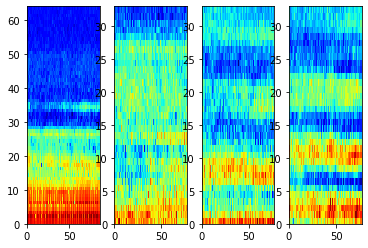

In [5]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

### CNN-model

In [20]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        self.frames_in_segment = config['data']['supra_frame_length']
        self.layer1_filt = 10
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        self.batch_norm1 = nn.BatchNorm2d(1)
        
        self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num,10),padding='valid',stride=(1,5))
        self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num,10),padding='valid',stride=(1,5))
        self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num,10),padding='valid',stride=(1,5))

        self.fc = nn.Linear(3*self.layer1_filt*16,1)    # 16 = np.round((self.frames_in_segment-10)/5).astype(int)
        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
        # print(x.shape)
        # print(x1.shape)
        # for param in self.conv_lf.parameters():
        #     print(param.data)
        #     print(param.data.shape)
        # print(self.conv_lf.weight())
        # print(x2.shape)
        # print(x3.shape)
        
        out1 = self.conv_lf(out1)
        out2 = self.conv_mf(out2)
        out3 = self.conv_hf(out3)
        
        # print(out1.shape)
        # print(out2.shape)
        # print(out3.shape)

        out1 = torch.tanh(out1)
        out2 = torch.tanh(out2)
        out3 = torch.tanh(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)        
        # print(out.shape)

        out = self.fc(out)
        return out    

#### training_loop

In [8]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/entire_model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        model.train()
        best_acc = 0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        # prediction on val set        
        val_score = list()
        loss_val = 0.0
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)
                pred = torch.squeeze(pred,1)                
                loss = loss_fn(pred, label)
                loss_val += loss.item()
                val_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)                        
                else:
                    pred = torch.tensor(0, dtype=torch.float64)
                if pred==label:
                    TP_TN_sum +=1
        acc_val = TP_TN_sum/len(val_score)    
        
        loss_train_history[epoch-1] = loss_train / len(train_loader)
        loss_val_history[epoch-1] = loss_val / len(val_loader)

        if acc_val>best_acc:
            torch.save(model, MODEL_PATH)

        if epoch==1 or epoch%2==0:                                                            
            print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
        lr_scheduler.step()
        
    model = torch.load(MODEL_PATH)

    fig, ax = plt.subplots(figsize=(10,4))
    plt.rcParams.update({'font.size': 14})
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)

### Single NN training & evaluation

In [48]:
# Test inference
model = ALS_CNN()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add chanel dimension
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)

torch.Size([1, 1, 64, 86])


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

# model = ALS_FFNN()
model = ALS_CNN()
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [24]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### Start script

Epoch 1: 100%|██████████| 125/125 [00:03<00:00, 34.68it/s]


2023-05-18 19:31:12.878230 Epoch 1, Train loss 0.437, Val loss 0.395, Acc_val = 0.88


Epoch 2: 100%|██████████| 125/125 [00:03<00:00, 35.32it/s]


2023-05-18 19:31:18.118981 Epoch 2, Train loss 0.214, Val loss 0.558, Acc_val = 0.66


Epoch 4: 100%|██████████| 125/125 [00:03<00:00, 35.33it/s]


2023-05-18 19:31:28.486886 Epoch 4, Train loss 0.099, Val loss 1.298, Acc_val = 0.59


Epoch 6: 100%|██████████| 125/125 [00:03<00:00, 35.14it/s]


2023-05-18 19:31:39.048484 Epoch 6, Train loss 0.062, Val loss 1.485, Acc_val = 0.59


Epoch 8: 100%|██████████| 125/125 [00:03<00:00, 36.73it/s]


2023-05-18 19:31:49.459540 Epoch 8, Train loss 0.045, Val loss 2.073, Acc_val = 0.48


Epoch 10: 100%|██████████| 125/125 [00:03<00:00, 36.76it/s]


2023-05-18 19:31:59.792083 Epoch 10, Train loss 0.033, Val loss 1.991, Acc_val = 0.47


Epoch 12: 100%|██████████| 125/125 [00:03<00:00, 35.28it/s]


2023-05-18 19:32:10.199865 Epoch 12, Train loss 0.026, Val loss 2.278, Acc_val = 0.47


Epoch 14: 100%|██████████| 125/125 [00:03<00:00, 34.88it/s]


2023-05-18 19:32:20.774924 Epoch 14, Train loss 0.021, Val loss 2.507, Acc_val = 0.46


Epoch 15: 100%|██████████| 125/125 [00:03<00:00, 34.76it/s]


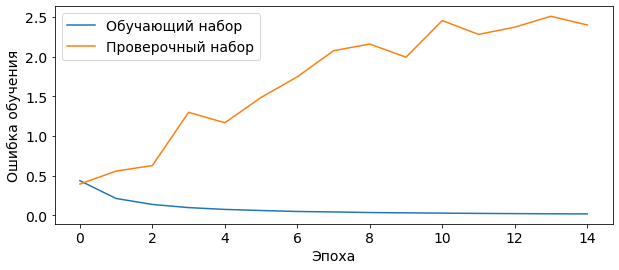

Acc =  0.540215484840892


Epoch 1: 100%|██████████| 132/132 [00:03<00:00, 35.93it/s]


2023-05-18 19:32:34.182616 Epoch 1, Train loss 0.596, Val loss 0.864, Acc_val = 0.15


Epoch 2: 100%|██████████| 132/132 [00:03<00:00, 35.33it/s]


2023-05-18 19:32:38.815095 Epoch 2, Train loss 0.419, Val loss 0.839, Acc_val = 0.39


Epoch 4: 100%|██████████| 132/132 [00:03<00:00, 35.94it/s]


2023-05-18 19:32:48.041595 Epoch 4, Train loss 0.243, Val loss 0.934, Acc_val = 0.45


Epoch 6: 100%|██████████| 132/132 [00:03<00:00, 40.58it/s]


2023-05-18 19:32:56.174254 Epoch 6, Train loss 0.181, Val loss 0.806, Acc_val = 0.51


Epoch 8: 100%|██████████| 132/132 [00:03<00:00, 41.11it/s]


2023-05-18 19:33:04.201455 Epoch 8, Train loss 0.144, Val loss 0.897, Acc_val = 0.51


Epoch 10: 100%|██████████| 132/132 [00:03<00:00, 42.04it/s]


2023-05-18 19:33:11.999424 Epoch 10, Train loss 0.126, Val loss 1.119, Acc_val = 0.48


Epoch 12: 100%|██████████| 132/132 [00:03<00:00, 40.79it/s]


2023-05-18 19:33:19.933985 Epoch 12, Train loss 0.113, Val loss 0.957, Acc_val = 0.52


Epoch 14: 100%|██████████| 132/132 [00:03<00:00, 40.19it/s]


2023-05-18 19:33:28.023448 Epoch 14, Train loss 0.106, Val loss 1.105, Acc_val = 0.52


Epoch 15: 100%|██████████| 132/132 [00:03<00:00, 41.61it/s]


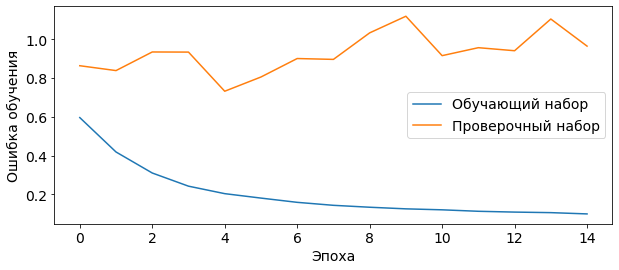

Acc =  0.6438194280311983


Epoch 1: 100%|██████████| 127/127 [00:03<00:00, 41.18it/s]


2023-05-18 19:33:39.443234 Epoch 1, Train loss 0.690, Val loss 0.718, Acc_val = 0.40


Epoch 2: 100%|██████████| 127/127 [00:03<00:00, 40.85it/s]


2023-05-18 19:33:43.620937 Epoch 2, Train loss 0.665, Val loss 0.702, Acc_val = 0.40


Epoch 4: 100%|██████████| 127/127 [00:03<00:00, 40.15it/s]


2023-05-18 19:33:51.785521 Epoch 4, Train loss 0.617, Val loss 0.657, Acc_val = 0.84


Epoch 6: 100%|██████████| 127/127 [00:03<00:00, 34.14it/s]


2023-05-18 19:34:01.553439 Epoch 6, Train loss 0.563, Val loss 0.618, Acc_val = 0.83


Epoch 8: 100%|██████████| 127/127 [00:03<00:00, 35.10it/s]


2023-05-18 19:34:11.321713 Epoch 8, Train loss 0.521, Val loss 0.595, Acc_val = 0.82


Epoch 10: 100%|██████████| 127/127 [00:03<00:00, 35.04it/s]


2023-05-18 19:34:21.058851 Epoch 10, Train loss 0.488, Val loss 0.589, Acc_val = 0.83


Epoch 12: 100%|██████████| 127/127 [00:03<00:00, 34.93it/s]


2023-05-18 19:34:30.806566 Epoch 12, Train loss 0.462, Val loss 0.583, Acc_val = 0.82


Epoch 14: 100%|██████████| 127/127 [00:03<00:00, 35.58it/s]


2023-05-18 19:34:40.457645 Epoch 14, Train loss 0.444, Val loss 0.573, Acc_val = 0.80


Epoch 15: 100%|██████████| 127/127 [00:03<00:00, 34.45it/s]


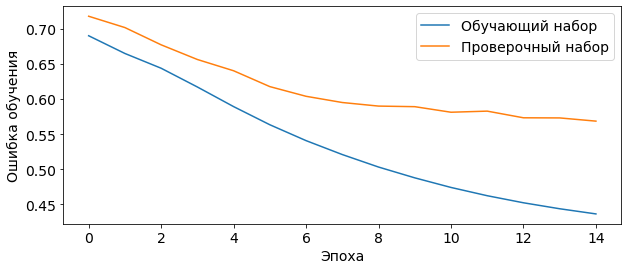

Acc =  0.5973756906077348


Epoch 1: 100%|██████████| 137/137 [00:03<00:00, 34.52it/s]


2023-05-18 19:34:54.349347 Epoch 1, Train loss 0.705, Val loss 0.708, Acc_val = 0.37


Epoch 2: 100%|██████████| 137/137 [00:04<00:00, 34.14it/s]


2023-05-18 19:34:59.416447 Epoch 2, Train loss 0.699, Val loss 0.706, Acc_val = 0.40


Epoch 4: 100%|██████████| 137/137 [00:03<00:00, 34.53it/s]


2023-05-18 19:35:09.286396 Epoch 4, Train loss 0.691, Val loss 0.701, Acc_val = 0.41


Epoch 6: 100%|██████████| 137/137 [00:03<00:00, 40.71it/s]


2023-05-18 19:35:18.348785 Epoch 6, Train loss 0.686, Val loss 0.695, Acc_val = 0.42


Epoch 8: 100%|██████████| 137/137 [00:03<00:00, 37.70it/s]


2023-05-18 19:35:27.517258 Epoch 8, Train loss 0.682, Val loss 0.690, Acc_val = 0.42


Epoch 10: 100%|██████████| 137/137 [00:03<00:00, 38.35it/s]


2023-05-18 19:35:36.513620 Epoch 10, Train loss 0.678, Val loss 0.685, Acc_val = 0.43


Epoch 12: 100%|██████████| 137/137 [00:03<00:00, 41.24it/s]


2023-05-18 19:35:44.985936 Epoch 12, Train loss 0.675, Val loss 0.681, Acc_val = 0.46


Epoch 14: 100%|██████████| 137/137 [00:03<00:00, 41.18it/s]


2023-05-18 19:35:53.495845 Epoch 14, Train loss 0.672, Val loss 0.676, Acc_val = 0.49


Epoch 15: 100%|██████████| 137/137 [00:03<00:00, 40.93it/s]


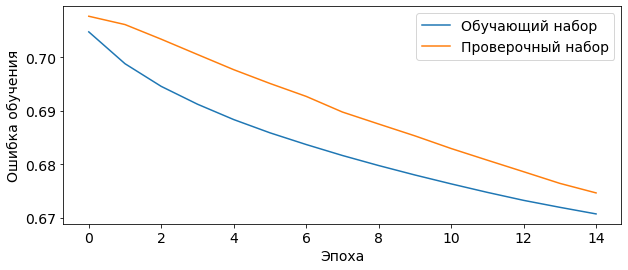

Acc =  0.654627539503386


Epoch 1: 100%|██████████| 125/125 [00:03<00:00, 40.28it/s]


2023-05-18 19:36:05.177570 Epoch 1, Train loss 0.704, Val loss 0.711, Acc_val = 0.31


Epoch 2: 100%|██████████| 125/125 [00:03<00:00, 39.25it/s]


2023-05-18 19:36:09.776834 Epoch 2, Train loss 0.703, Val loss 0.710, Acc_val = 0.36


Epoch 4: 100%|██████████| 125/125 [00:03<00:00, 34.07it/s]


2023-05-18 19:36:20.500315 Epoch 4, Train loss 0.700, Val loss 0.708, Acc_val = 0.42


Epoch 6: 100%|██████████| 125/125 [00:03<00:00, 34.12it/s]


2023-05-18 19:36:31.162232 Epoch 6, Train loss 0.698, Val loss 0.706, Acc_val = 0.47


Epoch 8: 100%|██████████| 125/125 [00:03<00:00, 34.38it/s]


2023-05-18 19:36:41.831447 Epoch 8, Train loss 0.696, Val loss 0.704, Acc_val = 0.49


Epoch 10: 100%|██████████| 125/125 [00:03<00:00, 35.28it/s]


2023-05-18 19:36:52.224382 Epoch 10, Train loss 0.695, Val loss 0.703, Acc_val = 0.50


Epoch 12: 100%|██████████| 125/125 [00:03<00:00, 34.21it/s]


2023-05-18 19:37:02.832594 Epoch 12, Train loss 0.694, Val loss 0.702, Acc_val = 0.51


Epoch 14: 100%|██████████| 125/125 [00:03<00:00, 34.68it/s]


2023-05-18 19:37:12.990649 Epoch 14, Train loss 0.694, Val loss 0.702, Acc_val = 0.52


Epoch 15: 100%|██████████| 125/125 [00:03<00:00, 35.02it/s]


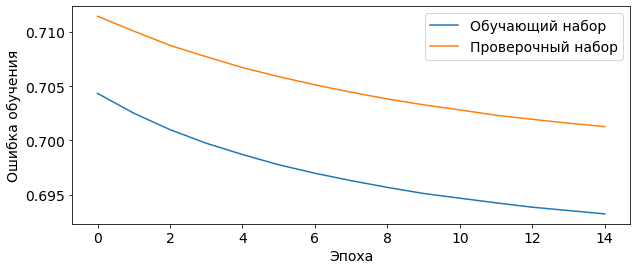

Acc =  0.4826388888888889
Final results
Acc_sk = 0.58
Prec = 0.57
Recall = 0.75
Sens = 0.75
Spec = 0.41


0.5840843301108745

In [25]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

In [60]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
